In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression

import pickle
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge

# load neural temporal pcs

In [2]:
###########################
### Pooled superfly PCA ###
###########################

file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210301_temporal.npy'
temporal_super = np.load(file)
temporal_super.shape #time by PC

(30456, 26840)

In [3]:
######################
### Individual PCA ###
######################

dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
temporal = {}
#temporal_concatenated = np.zeros((30456,3384))
for i, fly in enumerate(fly_names):
    print(fly)
    file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210301_temporal_indiv_pcs_fly{i}.npy'
    temporal[fly] = np.load(file)
    #temporal_concatenated[i*3384:(i+1)*3384,:] = temporal[fly]

fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


In [4]:
temporal['fly_099'].shape #time by pc

(3384, 3384)

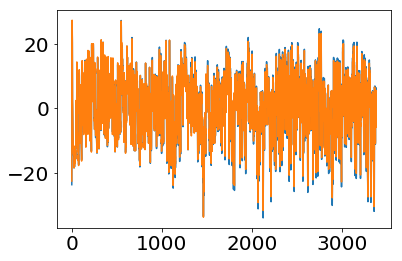

In [5]:
pc=0
plt.plot(temporal['fly_087'][:,pc])
plt.plot(temporal_super[:3384,pc]*-1)

In [6]:
# Note that first few pcs are extremly close between indiv pc and pooled pc, as expected
# and as pc_num increases, they are completely different

# load behavior

In [4]:
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                #self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))
                self.fictrac[short].append(low_res_behavior)

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)
                
            ### 10Hz interp ###
            expt_len = 1000*30*60
            sample_in_ms = 100
            x_hz10 = np.arange(0,expt_len,sample_in_ms)
            hz10_res_behavior = self.pull_from_interp_object(interp_object, x_hz10)
            self.fictrac[short + '_10hz'] = hz10_res_behavior
            self.fictrac[short + '_pos_10hz'] = np.clip(hz10_res_behavior, a_min=0, a_max=None)
            self.fictrac[short + '_neg_10hz'] = np.clip(hz10_res_behavior, a_min=None, a_max=0) * -1

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

In [5]:
flies = {}
for i, fly in enumerate(fly_names):
    print(F'*** fly: {fly} ***')
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()
    flies[fly].load_z_depth_correction()

*** fly: fly_087 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 68.75 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.31 sec
*** fly: fly_089 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 48.79 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.35 sec
*** fly: fly_094 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 70.72 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.37 sec
*** fly: fly_097 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 79.81 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.34 sec
*** fly: fly_098 ***

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 71.48 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.43 sec
*** fly: f

In [6]:
z = 20
sphere_radius = 4.5e-3 # in m
fps=50
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
behavior_super = {}
for behavior in behaviors:
    behavior_super[behavior] = []
    for fly in fly_names:
        behavior_super[behavior].extend((flies[fly].fictrac.fictrac[behavior][z]))
    behavior_super[behavior] = np.asarray(behavior_super[behavior])
    behavior_super[behavior + '_std'] = behavior_super[behavior]/np.std(behavior_super[behavior])
    
    if behavior == 'Y_pos':
        ''' starts with units of rad/frame
        * sphere_radius(m); now in m/frame
        * fps; now in m/sec
        * 1000; now in mm/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec
        
    elif behavior in ['Z_pos', 'Z_neg']:
        ''' starts with units of rad/frame
        * 180 / np.pi; now in deg/frame
        * fps; now in deg/sec '''
        behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

# fit models

In [ ]:
# RidgeCV is giving too high accuracy - something wrong with it.
# Lets manually fit this linear regression with regularization and cross-validation

# randomly split data into 5 folds
# loop over alphas
# for a given alpha, solve least squares for 4/5 folds, use coefs to predict 1/5 fold - save r2

In [7]:
### custom working k-fold ###

folds = 5
num_datapoints = 3384

random.seed(0)
indicies = list(range(num_datapoints))
random.shuffle(indicies)
fold_size = int(np.floor(num_datapoints/folds))

test_indicies = []
train_indicies = []
for fold in range(folds):
    test_indicies_ = indicies[fold*fold_size:(fold+1)*fold_size]
    train_indicies_ = [i for i in indicies if i not in test_indicies_]
    
    test_indicies.append(test_indicies_)
    train_indicies.append(train_indicies_)

In [240]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
alphas = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
num_pcss = [1,10,30,100,250,500,1000,2000]
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
use_super_pcs = True

fly_scores = {}
for k,fly in enumerate(fly_names):
    fly_scores[fly] = {}
    print(fly)
    t0=time.time()
    for behavior in behaviors:
        all_all_scores = []
        for num_pcs in num_pcss:
            Y = flies[fly].fictrac.fictrac[behavior][z]
            
            if use_super_pcs:
                start = k*3384
                end = (k+1)*3384
                X = temporal_super[start:end,:num_pcs]
            else:
                X = temporal[fly][:,:num_pcs] #time by pc

            all_scores = []
            for alpha in alphas:
                scores = []
                for fold in range(folds):
                    model = Ridge(alpha=alpha).fit(X[train_indicies[fold],:],Y[train_indicies[fold]])
                    scores.append(model.score(X[test_indicies[fold],:],Y[test_indicies[fold]]))
                all_scores.append(np.mean(scores))
            all_all_scores.append(all_scores)
        print(time.time()-t0)

        max_scores_per_pcs = []
        max_scores_per_pcs_alpha = []
        for i,num_pcs in enumerate(num_pcss):
            max_scores_per_pcs.append(np.max(all_all_scores[i]))
            max_scores_per_pcs_alpha.append(np.argmax(all_all_scores[i]))

        fly_scores[fly][behavior] = max_scores_per_pcs
        fly_scores[fly][behavior + '_alpha'] = max_scores_per_pcs_alpha

fly_087
28.52285671234131
57.00551223754883
85.55880379676819
fly_089
28.459078788757324
56.948474645614624
85.41398859024048
fly_094
28.48347806930542
56.91757035255432
85.37579870223999
fly_097
28.563475131988525
57.15512943267822
85.69230365753174
fly_098
28.49417805671692
56.99478721618652
85.60418057441711
fly_099
28.692034244537354
57.388325452804565
86.07461452484131
fly_100
28.681928634643555
57.37753176689148
86.06276941299438
fly_101
28.660881519317627
57.16468811035156
85.70628428459167
fly_105
28.549468994140625
57.114532470703125
85.68968224525452


In [250]:
behavior='Z_neg'
for fly in fly_names:
    print(fly_scores[fly][behavior + '_alpha'])

[10, 9, 9, 9, 10, 10, 10, 10]
[10, 9, 9, 10, 10, 10, 11, 11]
[10, 10, 9, 10, 10, 10, 10, 11]
[10, 9, 9, 9, 10, 10, 10, 10]
[10, 9, 9, 9, 10, 10, 10, 11]
[10, 8, 9, 9, 10, 10, 10, 10]
[9, 8, 9, 9, 10, 10, 10, 10]
[9, 9, 9, 9, 10, 10, 10, 10]
[10, 9, 10, 10, 10, 11, 11, 11]


In [232]:
alphas[10]

1000.0

In [24]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']

num_pcs = 100
alpha = 1000

full_scores = {}
full_coefs = {}

for pc_type in ['super', 'indiv']:
    full_scores[pc_type] = {}
    full_coefs[pc_type] = {}
    
    for k,fly in enumerate(fly_names):
        print(fly)
        full_scores[pc_type][fly] = {}
        full_coefs[pc_type][fly] = {}
        
        for behavior in behaviors:
            start = k*3384
            end = (k+1)*3384
            
            if pc_type == 'super':
                X = temporal_super[start:end,:num_pcs]
            elif pc_type == 'indiv':
                X = temporal[fly][:,:num_pcs] #time by pc
                
            Y = behavior_super[behavior + '_std'][start:end]

            model = Ridge(alpha=alpha).fit(X,Y)
            
            full_scores[pc_type][fly][behavior] = model.score(X,Y)
            full_coefs[pc_type][fly][behavior] = model.coef_

fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105
fly_087
fly_089
fly_094
fly_097
fly_098
fly_099
fly_100
fly_101
fly_105


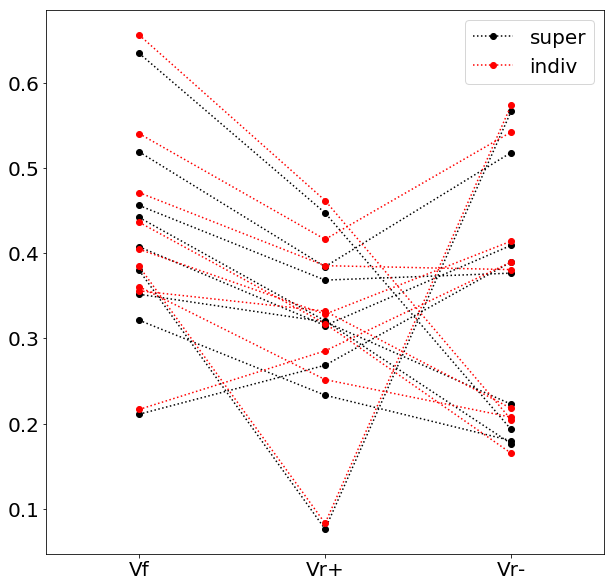

In [25]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)

colors = {'super': 'k', 'indiv': 'r'}
for pc_type in ['super', 'indiv']:
    for i, fly in enumerate(fly_names):
        if i == 0:
            label = pc_type
        else:
            label = None
        ax.plot([1,2,3], [full_scores[pc_type][fly]['Y_pos'],
                          full_scores[pc_type][fly]['Z_pos'],
                          full_scores[pc_type][fly]['Z_neg']],
                          linestyle=':', marker='o',color = colors[pc_type],label=label)
    
    
plt.legend()
ax.set_xticklabels(['Vf', 'Vr+', 'Vr-'])
ax.set_xticks([1, 2, 3])
ax.set_xlim(0.5,3.5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [121]:
num_pcs = 100
alpha = 1000
k=0
start = k*3384
end = (k+1)*3384
behavior = 'Y_pos'

Ys = {}
Y_hats = {}
for behavior in behaviors:
    X = temporal_super[start:end,:num_pcs]
    Y = behavior_super[behavior + '_units'][start:end]

    model = Ridge(alpha=alpha).fit(X,Y)
    Y_hat = model.predict(X)
    
    Ys[behavior] = Y
    Y_hats[behavior] = Y_hat

In [154]:
temporal['fly_087'].shape #time by pc

(3384, 3384)

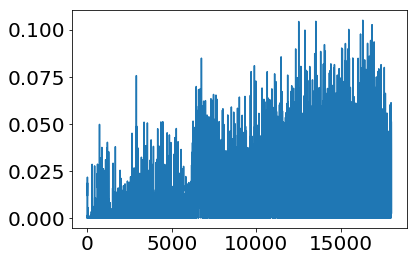

In [159]:
plt.plot(flies['fly_087'].fictrac.fictrac['Y_pos_10hz'])

In [194]:
### Interp PCs to 10Hz for behavior trace ###

# make interp object
x_original = flies['fly_087'].timestamps[:,20]
interp_object = interp1d(x_original, temporal['fly_087'], bounds_error = False, axis=0, kind='cubic')

# pull from interp object
expt_len = 1000*30*60
sample_in_ms = 100
x_hz10 = np.arange(0,expt_len,sample_in_ms)

pcs_10hz = interp_object(x_hz10)
np.nan_to_num(pcs_10hz, copy=False);

#################
### Fit model ###
#################
num_pcs = 100
alpha = 1000

Ys_10hz = {}
Y_hats_10hz = {}
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
for behavior in behaviors:
    X = pcs_10hz[:,:num_pcs]
    Y = flies['fly_087'].fictrac.fictrac[behavior + '_10hz']
    if behavior in ['Y_pos']:
        Y = Y * sphere_radius * fps * 1000 # mm/sec
    elif behavior in ['Z_pos', 'Z_neg']:
        Y = Y * 180 / np.pi * fps ## deg/sec

    model = Ridge(alpha=alpha).fit(X,Y)
    print(model.score(X,Y))
    Y_hat = model.predict(X)
    
    Ys_10hz[behavior] = Y
    Y_hats_10hz[behavior] = Y_hat

0.4665285220093255
0.2667105108117741
0.37714037862780453


In [ ]:
0.4665285220093255
0.2667105108117741
0.37714037862780453

In [ ]:
    behavior_super[behavior + '_units'] = behavior_super[behavior] * sphere_radius * fps * 1000 # mm/sec

elif behavior in ['Z_pos', 'Z_neg']:
    ''' starts with units of rad/frame
    * 180 / np.pi; now in deg/frame
    * fps; now in deg/sec '''
    behavior_super[behavior + '_units'] = behavior_super[behavior] * 180 / np.pi * fps ## deg/sec

In [178]:
num_pcs = 100
alpha = 1000
k=0
start = k*3384
end = (k+1)*3384
behavior = 'Y_pos'

Ys = {}
Y_hats = {}
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
for behavior in behaviors:
    X = temporal_super[start:end,:num_pcs]
    Y = behavior_super[behavior + '_units'][start:end]

    model = Ridge(alpha=alpha).fit(X,Y)
    print(model.score(X,Y))
    Y_hat = model.predict(X)
    
    Ys[behavior] = Y
    Y_hats[behavior] = Y_hat

0.518943701744202
0.3842369229066625
0.5180934952041614


In [156]:
pcs_10hz.shape

(18000, 3384)

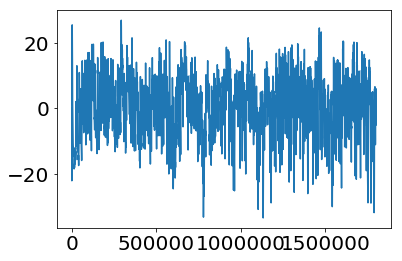

In [158]:
plt.plot(x_hz10,pcs_10hz[:,0])

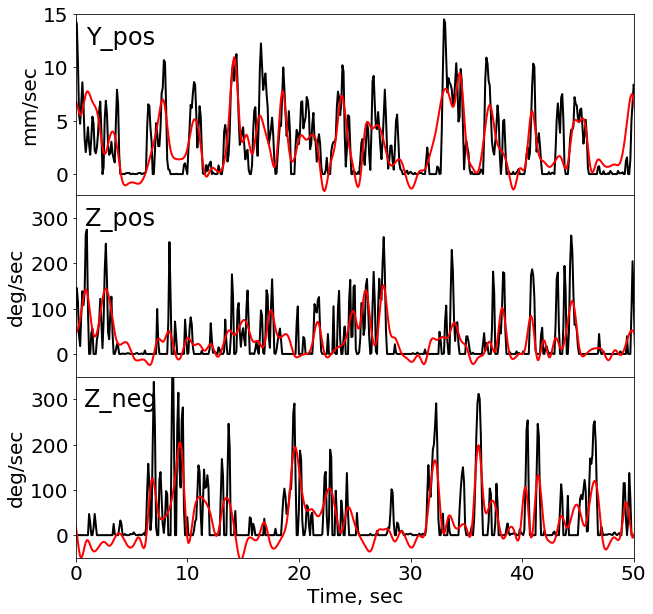

In [258]:
plt.figure(figsize=(10,10))

for k, behavior in enumerate(behaviors):
    ax = plt.gca()
    plt.subplot(3,1,k+1)
    plt.plot(Ys_10hz[behavior],color='k',lw=2)
    plt.plot(Y_hats_10hz[behavior],color='r',lw=2)
    plt.title(behavior,y=.8,x=.08)
    start = 9000
    plt.xlim(start,start+500) # each point here is 100ms
    if k < 3:
        ax.xaxis.set_visible(False)
    else:
        print(k)
        
    ax = plt.gca()
    ax.set_xticks([9000,9100,9200,9300,9400,9500])
    ax.set_xticklabels([0,10,20,30,40,50])
    
    if k == 0:
        plt.ylabel('mm/sec')
        plt.ylim(-2,15)
        
    if k in [1,2]:
        plt.ylabel('deg/sec')
        plt.ylim(-50,350)
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Time, sec')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [259]:
temporal_super.shape

(30456, 26840)

In [290]:
flies["fly_087"].timestamps[:,20]

array([2.79079712e+02, 8.11075413e+02, 1.34307111e+03, ...,
       1.79895654e+06, 1.79948854e+06, 1.80002054e+06])

In [297]:
200*((8.11075413e+02 - 2.79079712e+02)/1000)

106.3991402

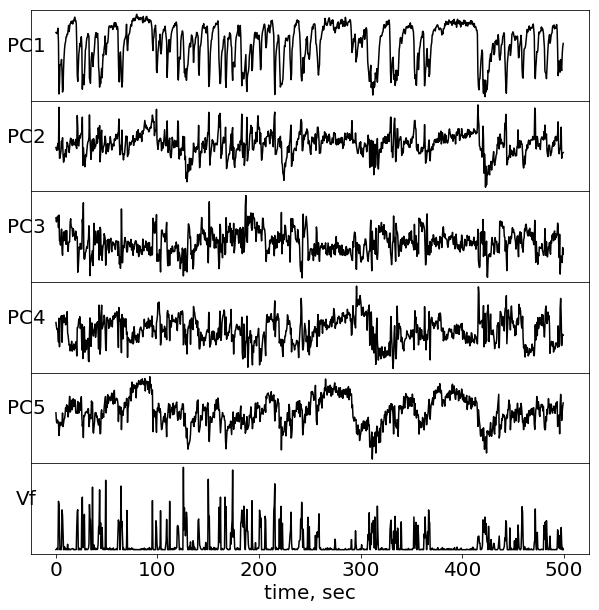

In [313]:
plt.figure(figsize=(10,10))
start = 8000
end = 9000

for i in range(6):
    plt.subplot(6,1,i+1)
    if i == 5:
        plt.plot(behavior_super['Y_pos_std'][start:end],color='k')
        plt.ylabel('Vf',rotation = 0,x=-100)
        ax = plt.gca()
        ax.set_yticks([])
    else:
        plt.plot(temporal_super[start:end,i],color='k')
        plt.ylabel(f'PC{i+1}',rotation = 0,x=-1000)
        ax = plt.gca()
        ax.set_yticks([])
    ax = plt.gca()
    ax.set_xticks([0,200,400,600,800,1000])
    ax.set_xticklabels([0,100,200,300,400,500])
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel("time, sec")

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

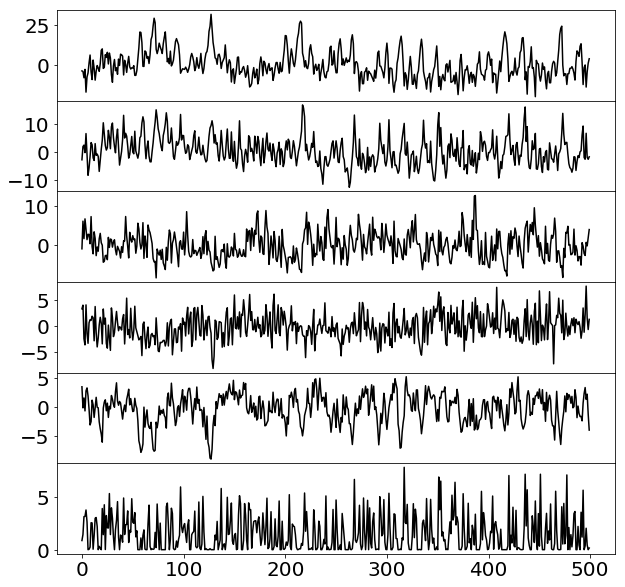

In [288]:
plt.figure(figsize=(10,10))
start = 2000
end = 2500

for i in range(6):
    plt.subplot(6,1,i+1)
    if i == 5:
        plt.plot(behavior_super['Y_pos_std'][start:end],color='k')
    else:
        plt.plot(temporal_super[start:end,i],color='k')

plt.subplots_adjust(wspace=0, hspace=0)


In [ ]:
plt.figure(figsize=(10,10))

for k, behavior in enumerate(behaviors):
    ax = plt.gca()
    plt.subplot(3,1,k+1)
    plt.plot(Ys_10hz[behavior])
    plt.plot(Y_hats_10hz[behavior])
    plt.title(behavior)
    plt.xlim(10000,11000) # each point here is 100ms
    if k < 3:
        ax.xaxis.set_visible(False)
    else:
        print(k)

#plt.subplots_adjust(wspace=0, hspace=0)

(10000, 11000)

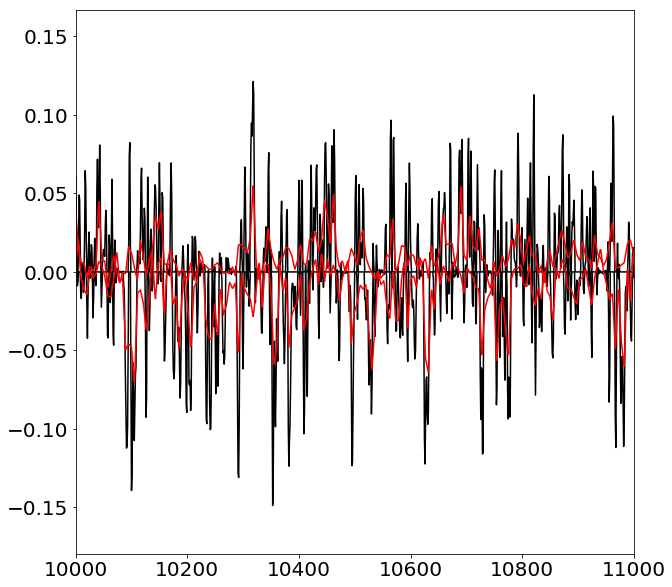

In [173]:
plt.figure(figsize=(10,10))

plt.plot(Ys_10hz['Z_pos'],color='k')
plt.plot(Ys_10hz['Z_neg']*-1,color='k')

plt.plot(Y_hats_10hz['Z_pos'],color='r')
plt.plot(Y_hats_10hz['Z_neg']*-1,color='r')


plt.xlim(10000,11000) # each point here is 100ms


In [ ]:
#at .5hz, 100 points is 50sec
#I think I need to temporally upsample to get a better prediction trace

In [288]:


full_scores[fly][behavior]

3.0

No handles with labels found to put in legend.


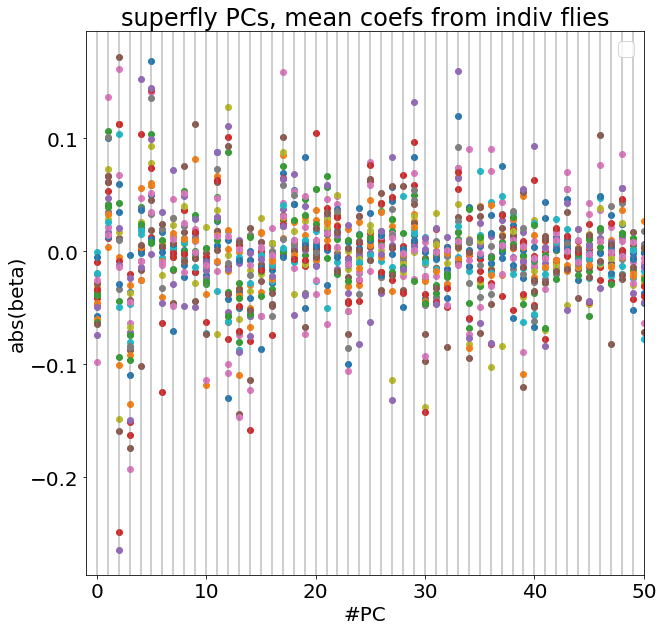

In [47]:
plt.figure(figsize=(10,10))

coef_means = {}
for behavior in behaviors:
    for_mean = []
    for fly in fly_names:
        coefs = np.abs(full_coefs[fly][behavior])    
        for_mean.append(coefs)
        plt.plot(full_coefs[fly][behavior],'o')
    means = np.mean(for_mean,axis=0)
    coef_means[behavior] = means
    #stds = np.std(for_mean,axis=0)
    #plt.plot(means,label=behavior,marker='o')
    #plt.errorbar(list(range(100)), means, stds/np.sqrt(9), linestyle='None', marker='o', label=behavior)

#lr = coef_means['Z_pos']-coef_means['Z_neg']
#plt.plot(lr,label='L/R diff',marker='o',linestyle='None')
#plt.plot(coef_means['Y_pos']-lr,label='fwd/turn diff',marker='o',linestyle='None')  

for i in range(50):
    plt.axvline(i,color='grey',alpha=.5)

# plt.plot(coef_means['Y_pos'],'o')
# plt.plot(coef_means['Z_pos'],'o')
# plt.plot(coef_means['Z_neg'],'o')

plt.legend()
plt.ylabel('abs(beta)')
plt.xlabel('#PC')
plt.title('superfly PCs, mean coefs from indiv flies')
plt.xlim(-1,50)


#plt.axvline(33)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

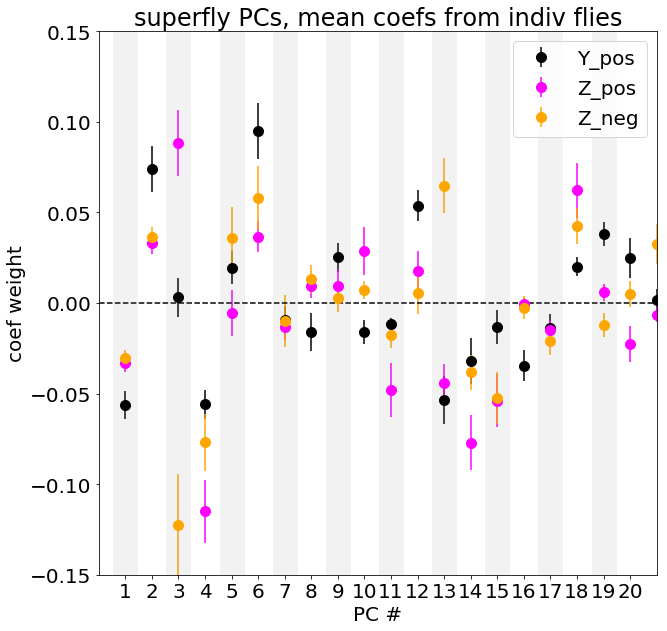

In [110]:
plt.figure(figsize=(10,10))
plt.axhline(0,color='k',linestyle='--')

for i in range(0,20,2):
    plt.axvline(i,color='grey',lw=25,alpha=.1)

colors=['k','magenta','orange']
for k, behavior in enumerate(behaviors):
    for_mean = []
    for fly in fly_names:
        coefs = full_coefs[fly][behavior] 
        for_mean.append(coefs)
        #plt.plot(full_coefs[fly][behavior],'o',color=colors[k],ms=3)
    means = np.mean(for_mean,axis=0)
    stds = np.std(for_mean,axis=0)
    
    #plt.plot(means,'o',color=colors[k],ms=10)
    plt.errorbar(list(range(100)), means, stds/3, linestyle='None', marker='o', label=behavior, color=colors[k],ms=10)

    
plt.legend()
plt.ylabel('coef weight')
plt.xlabel('PC #')
plt.title('superfly PCs, mean coefs from indiv flies')
plt.xticks(list(range(0,20)))
#plt.xtick_labels([1,5,10,15,20])
ax = plt.gca()
ax.set_xticklabels(list(range(1,21)))
    
plt.xlim(-1,20)
plt.ylim(-.15,.15)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [90]:
stds

array([0.02322076, 0.03855858, 0.03242224, 0.02390198, 0.02790784,
       0.0459006 , 0.02200865, 0.03152112, 0.02352041, 0.01922564,
       0.01082806, 0.02549146, 0.04027893, 0.03799436, 0.0280933 ,
       0.02547085, 0.02465319, 0.01515192, 0.01993761, 0.03343586,
       0.01803019, 0.02517762, 0.01931124, 0.02955514, 0.02040312,
       0.02236755, 0.01873796, 0.0241836 , 0.01829251, 0.03123793,
       0.01702606, 0.0240224 , 0.01523442, 0.02965083, 0.0370059 ,
       0.02339899, 0.02969941, 0.02220363, 0.02370998, 0.02176406,
       0.01882546, 0.01827353, 0.00859   , 0.02281605, 0.00528839,
       0.0171097 , 0.01516869, 0.02061607, 0.02445514, 0.01829008,
       0.02327831, 0.01066286, 0.02537932, 0.0215331 , 0.01357821,
       0.02000804, 0.0178019 , 0.01639664, 0.01065994, 0.0159039 ,
       0.01722852, 0.01789324, 0.00904924, 0.02549103, 0.00924329,
       0.02803869, 0.01979913, 0.01688954, 0.01357504, 0.01426367,
       0.02462217, 0.0123376 , 0.01851941, 0.03530277, 0.02596

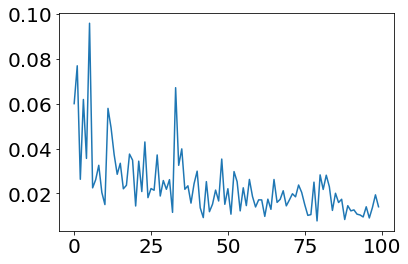

In [265]:
plt.plot(np.mean(for_mean,axis=0))

In [252]:
for fly in fly_names:
    for behavior in behaviors:
        print(f'{fly}, {behavior}, {full_scores[fly][behavior]}')

fly_087, Y_pos, 0.518943701744202
fly_087, Z_pos, 0.38423692290666267
fly_087, Z_neg, 0.5180934952041611
fly_089, Y_pos, 0.44195863994059537
fly_089, Z_pos, 0.32066961563878904
fly_089, Z_neg, 0.17663100088277806
fly_094, Y_pos, 0.6345759819473331
fly_094, Z_pos, 0.4473164993514901
fly_094, Z_neg, 0.19325211513297647
fly_097, Y_pos, 0.21110076922468324
fly_097, Z_pos, 0.26852738037821333
fly_097, Z_neg, 0.3896477688894905
fly_098, Y_pos, 0.3518333121402597
fly_098, Z_pos, 0.3195143419047817
fly_098, Z_neg, 0.2228790670249109
fly_099, Y_pos, 0.38000783363196655
fly_099, Z_pos, 0.07635936643897923
fly_099, Z_neg, 0.5662873754544351
fly_100, Y_pos, 0.40752512147308423
fly_100, Z_pos, 0.3151231866855187
fly_100, Z_neg, 0.40919112330721497
fly_101, Y_pos, 0.45600664760146803
fly_101, Z_pos, 0.3684550636229479
fly_101, Z_neg, 0.37659810002066596
fly_105, Y_pos, 0.3213634483667417
fly_105, Z_pos, 0.2334334199320195
fly_105, Z_neg, 0.18010745202699063


In [22]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210302_pca_behavior_prediction/20210302_scores'
import pickle
with open(file, 'wb') as handle:
    pickle.dump(fly_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [134]:
#################
### Super Fly ###
#################

### custom working k-fold ###

folds = 5
num_datapoints = 30456

random.seed(0)
indicies = list(range(num_datapoints))
random.shuffle(indicies)
fold_size = int(np.floor(num_datapoints/folds))

test_indicies = []
train_indicies = []
for fold in range(folds):
    test_indicies_ = indicies[fold*fold_size:(fold+1)*fold_size]
    train_indicies_ = [i for i in indicies if i not in test_indicies_]
    
    test_indicies.append(test_indicies_)
    train_indicies.append(train_indicies_)

#################################
    
alphas = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
num_pcss = [1,10,30,100,250,500,1000,2000]
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']

super_scores = {}
for behavior in behaviors:
    t0=time.time()
    all_all_scores = []
    for num_pcs in num_pcss:
        print(num_pcs)
        Y = np.asarray(behavior_super[behavior])
        X = temporal_super[:,:num_pcs] #time by pc

        all_scores = []
        for alpha in alphas:
            scores = []
            for fold in range(folds):
                model = Ridge(alpha=alpha).fit(X[train_indicies[fold],:],Y[train_indicies[fold]])
                scores.append(model.score(X[test_indicies[fold],:],Y[test_indicies[fold]]))
            all_scores.append(np.mean(scores))
        all_all_scores.append(all_scores)
    print(time.time()-t0)

    max_scores_per_pcs = []
    for i,num_pcs in enumerate(num_pcss):
        max_scores_per_pcs.append(np.max(all_all_scores[i]))

    super_scores[behavior] = max_scores_per_pcs

1
10
30
100
250
500
1000
2000
170.94105052947998
1
10
30
100
250
500
1000
2000
171.0595498085022
1
10
30
100
250
500
1000
2000
171.3425703048706


In [137]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210302_pca_behavior_prediction/20210302_scores_superfly'
import pickle
with open(file, 'wb') as handle:
    pickle.dump(super_scores, handle, protocol=pickle.HIGHEST_PROTOCOL)

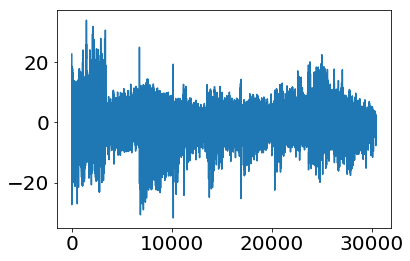

In [138]:
plt.plot(temporal_super[:,0])

In [180]:
from mpl_toolkits.mplot3d import Axes3D

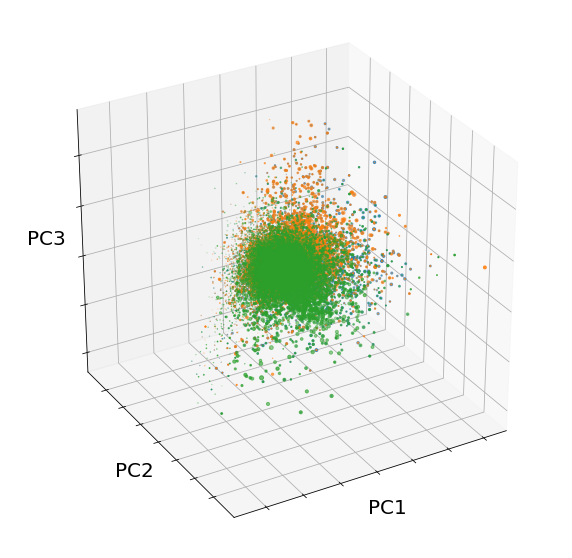

In [225]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

# ax.scatter(temporal['fly_087'][:,0],
#             temporal['fly_087'][:,1],
#             temporal['fly_087'][:,2],
#             c=flies['fly_087'].fictrac.fictrac['Y_pos'][z],s=10,vmin=0,vmax=.05)

ax.scatter(temporal_super[:,0],
            temporal_super[:,1],
            temporal_super[:,2],s=np.asarray(behavior_super['Y_pos'])*100,vmin=0,vmax=.05)

ax.scatter(temporal_super[:,0],
            temporal_super[:,1],
            temporal_super[:,2],s=np.asarray(behavior_super['Z_pos'])*100,vmin=0,vmax=.05)

ax.scatter(temporal_super[:,0],
            temporal_super[:,1],
            temporal_super[:,2],s=np.asarray(behavior_super['Z_neg'])*100,vmin=0,vmax=.05)

# ax.plot(temporal['fly_087'][:,0],
#             temporal['fly_087'][:,1],
#             temporal['fly_087'][:,2],lw=.1)

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

angle=60#110
ax.view_init(30, angle)



save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [221]:
len(behavior_super['Y_pos']*100)

3045600

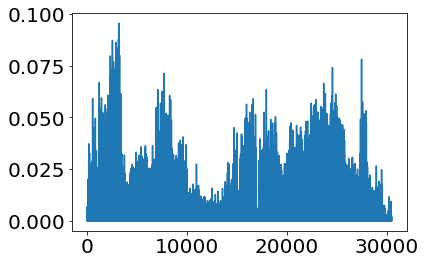

In [219]:
plt.plot(behavior_super['Y_pos'])

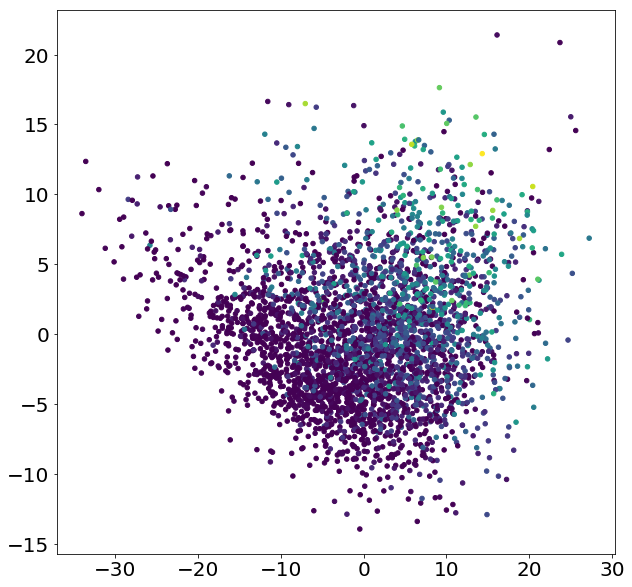

In [169]:
plt.figure(figsize=(10,10))
plt.scatter(temporal['fly_087'][:,0],
            temporal['fly_087'][:,1],
            c=flies['fly_087'].fictrac.fictrac['Y_pos'][z],s=20)

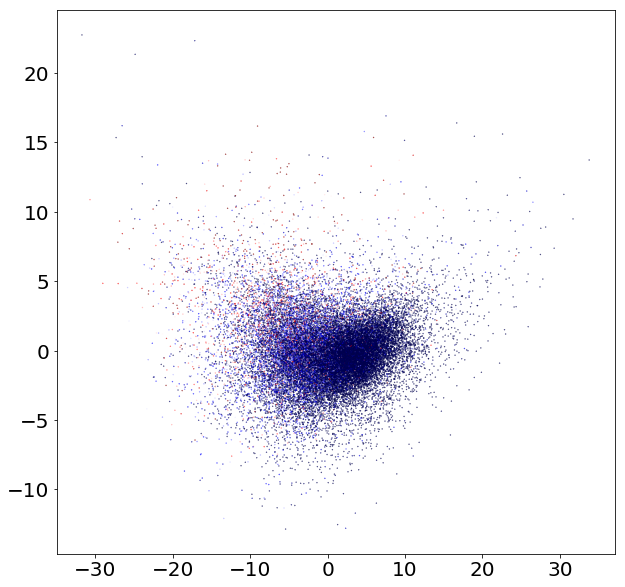

In [178]:
plt.figure(figsize=(10,10))
plt.scatter(temporal_super[:,0],
            temporal_super[:,1],
            c=behavior_super['Y_pos'],s=.1,cmap='seismic',vmin=0,vmax=.05)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

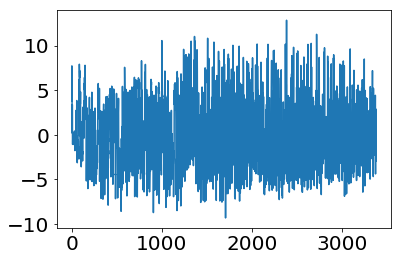

In [142]:
plt.plot(temporal['fly_087'][:,2])

# Can start here - load scores

In [9]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210302_pca_behavior_prediction/20210302_scores'
with open(file, 'rb') as handle:
    fly_scores = pickle.load(handle)

In [10]:
file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210302_pca_behavior_prediction/20210302_scores_superfly'
with open(file, 'rb') as handle:
    super_scores = pickle.load(handle)

EOFError: Ran out of input

In [12]:
os.path.exists(file)

True

NameError: name 'super_scores' is not defined

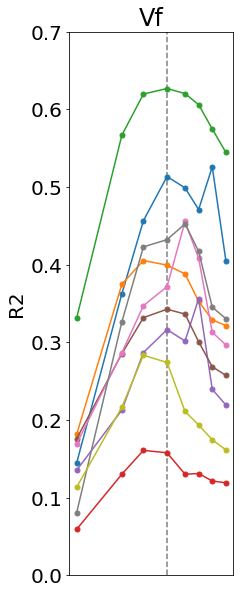

In [6]:
fig = plt.figure(figsize=(10,10))
titles = ['Vf', 'Vr+', 'Vr-']
behaviors = ['Y_pos', 'Z_pos', 'Z_neg']
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
#alphas = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
num_pcss = [1,10,30,100,250,500,1000,2000]

for k,behavior in enumerate(behaviors):
    plt.subplot(1,3,k+1)
    ax = plt.gca()
    if k > 0:
        ax.yaxis.set_visible(False)
    else:
        plt.ylabel('R2')
    plt.title(titles[k])
    if k == 1:
        plt.xlabel('#PCs')
    else:
        ax.xaxis.set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=12)
    
    plt.axvline(100,color='grey',linestyle='--')
    for fly in fly_names:
        plt.plot(num_pcss,fly_scores[fly][behavior],marker='o',label=fly,ms=5)
        plt.xscale('log')
    plt.ylim(0,.7)
    
    plt.plot(num_pcss,super_scores[behavior],marker='o',label='superfly',ms=5,color='k',linewidth=5)

plt.subplots_adjust(wspace=0, hspace=0)
ax.legend(bbox_to_anchor=(1.1, 1))
plt.suptitle('Superfly PCs')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

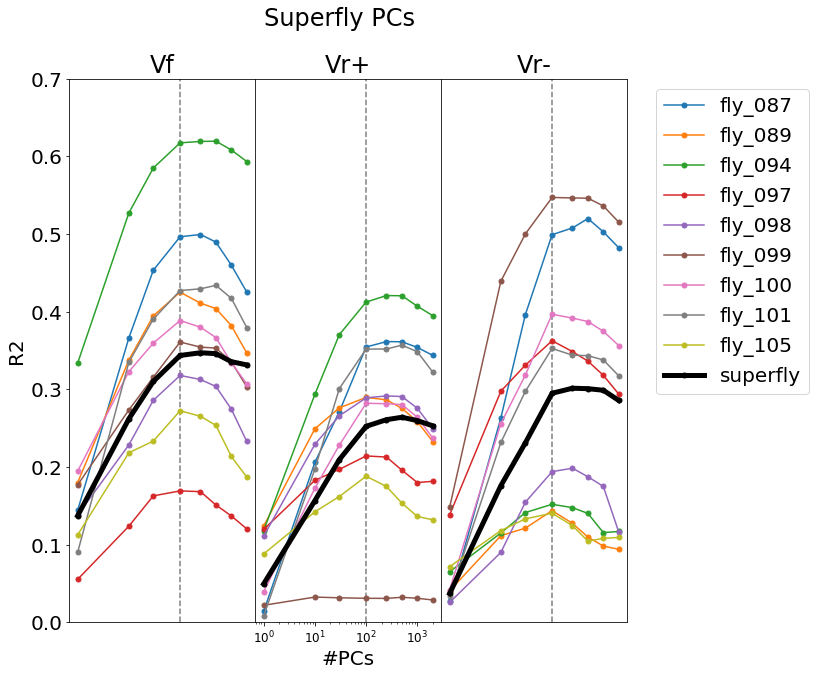

In [244]:
fig = plt.figure(figsize=(10,10))
titles = ['Vf', 'Vr+', 'Vr-']

for k,behavior in enumerate(behaviors):
    plt.subplot(1,3,k+1)
    ax = plt.gca()
    if k > 0:
        ax.yaxis.set_visible(False)
    else:
        plt.ylabel('R2')
    plt.title(titles[k])
    if k == 1:
        plt.xlabel('#PCs')
    else:
        ax.xaxis.set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=12)
    
    plt.axvline(100,color='grey',linestyle='--')
    for fly in fly_names:
        plt.plot(num_pcss,fly_scores[fly][behavior],marker='o',label=fly,ms=5)
        plt.xscale('log')
    plt.ylim(0,.7)
    
    plt.plot(num_pcss,super_scores[behavior],marker='o',label='superfly',ms=5,color='k',linewidth=5)

plt.subplots_adjust(wspace=0, hspace=0)
ax.legend(bbox_to_anchor=(1.1, 1))
plt.suptitle('Superfly PCs')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

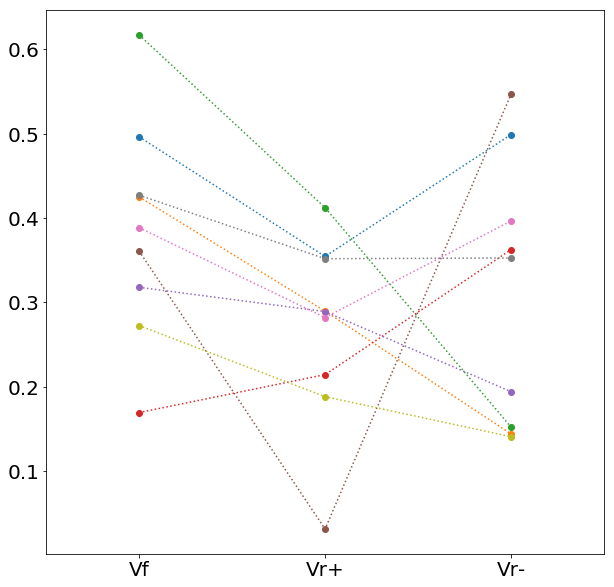

In [245]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
for i, fly in enumerate(fly_names):
    corrected = {}
    for behavior in behaviors:
        behavior_correction = np.mean(flies[fly].fictrac.fictrac[behavior][z])
        corrected[behavior]=fly_scores[fly][behavior][3]#*behavior_correction
    ax.plot([1,2,3], [corrected['Y_pos'], corrected['Z_pos'], corrected['Z_neg']],
            linestyle=':',marker='o')
ax.set_xticklabels(['Vf', 'Vr+', 'Vr-'])
ax.set_xticks([1, 2, 3])
ax.set_xlim(0.5,3.5)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

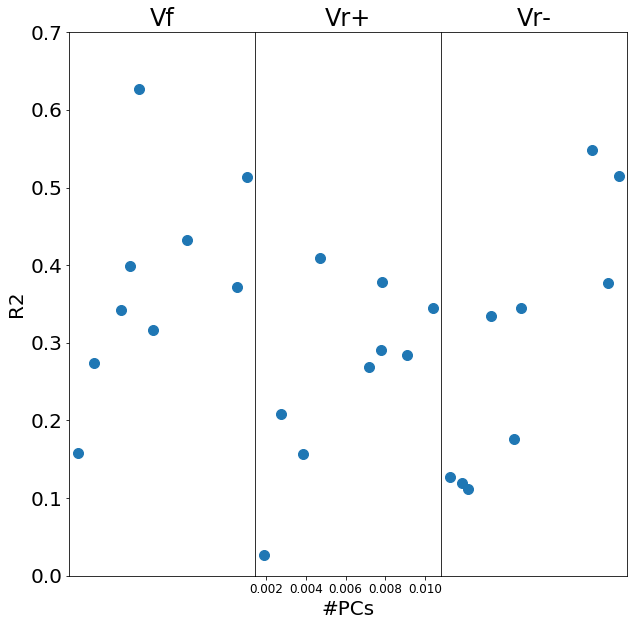

In [105]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
titles = ['Vf', 'Vr+', 'Vr-']

for k,behavior in enumerate(behaviors):
    plt.subplot(1,3,k+1)
    ax = plt.gca()

    xs=[];ys=[]
    for i, fly in enumerate(fly_names):
        xs.append(np.mean(flies[fly].fictrac.fictrac[behavior][z]))
        ys.append(fly_scores[fly][behavior][3])

    ax.plot(xs,ys,'o',color='k',ms=10)

    if k > 0:
        ax.yaxis.set_visible(False)
    else:
        plt.ylabel('R2')
    plt.title(titles[k])
    if k == 1:
        plt.xlabel('#PCs')
    else:
        ax.xaxis.set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=12)
    plt.ylim(0,.7)
plt.subplots_adjust(wspace=0, hspace=0)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

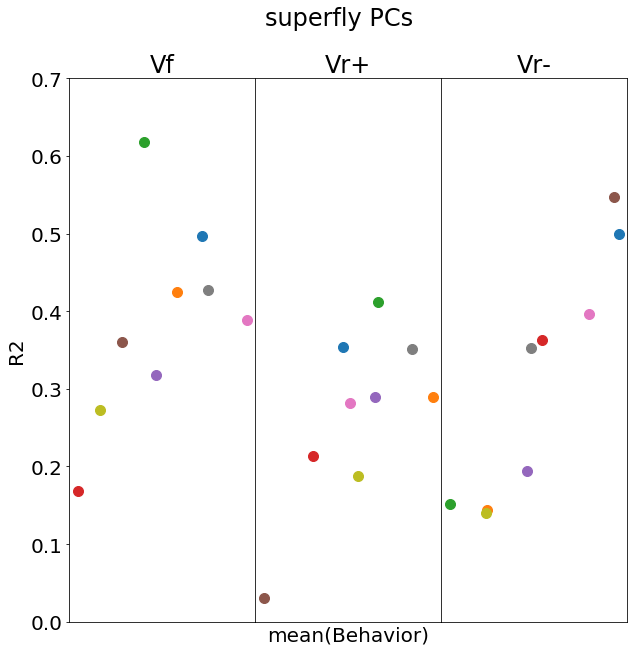

In [247]:
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
titles = ['Vf', 'Vr+', 'Vr-']

for k,behavior in enumerate(behaviors):
    plt.subplot(1,3,k+1)
    ax = plt.gca()

    for i, fly in enumerate(fly_names):
        x=np.mean(flies[fly].fictrac.fictrac[behavior][z])
        y=fly_scores[fly][behavior][3]

        ax.plot(x,y,'o',ms=10)

    if k > 0:
        ax.yaxis.set_visible(False)
    else:
        plt.ylabel('R2')
    plt.title(titles[k])
    if k == 1:
        plt.xlabel('mean(Behavior)')
    else:
        ax.xaxis.set_visible(False)
    ax.tick_params(axis='x', which='major', labelsize=12)
    plt.ylim(0,.7)
    #ax.set_xticklabels([])
    plt.xticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('superfly PCs')

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

In [287]:
max_scores_per_pcs = []
for i,num_pcs in enumerate(num_pcss):
    max_scores_per_pcs.append(np.max(all_all_scores[i]))

Text(0, 0.5, 'test R2')

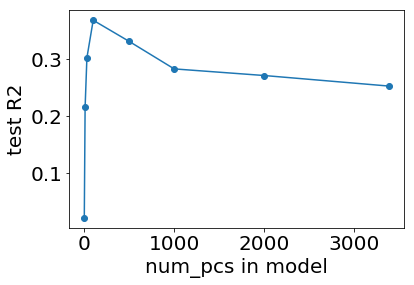

In [292]:
plt.plot(num_pcss,max_scores_per_pcs,marker='o')
plt.xlabel('num_pcs in model')
plt.ylabel('test R2')

Text(0.5, 0, 'alpha')

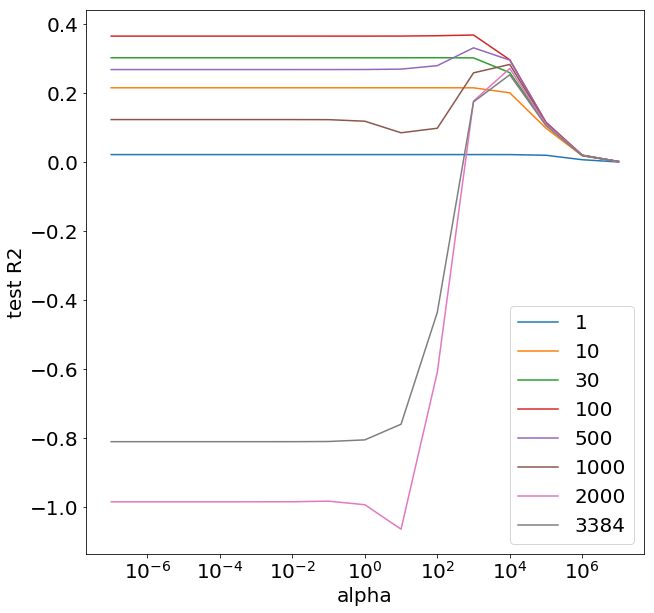

In [286]:
plt.figure(figsize=(10,10))
for i,num_pcs in enumerate(num_pcss):
    plt.plot(alphas,all_all_scores[i],label=num_pcs)
plt.xscale('log')
plt.legend()
plt.ylabel('test R2')
plt.xlabel('alpha')

(1000, 1100)

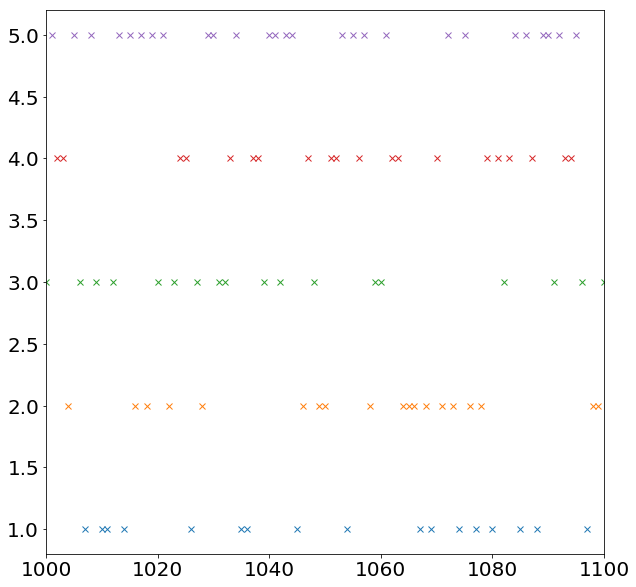

In [269]:
plt.figure(figsize=(10,10))
for i in range(5):
    plt.plot(test_indicies[i],np.ones(len(test_indicies[0]))+i,'x')

plt.xlim(1000,1100)

(1000, 1100)

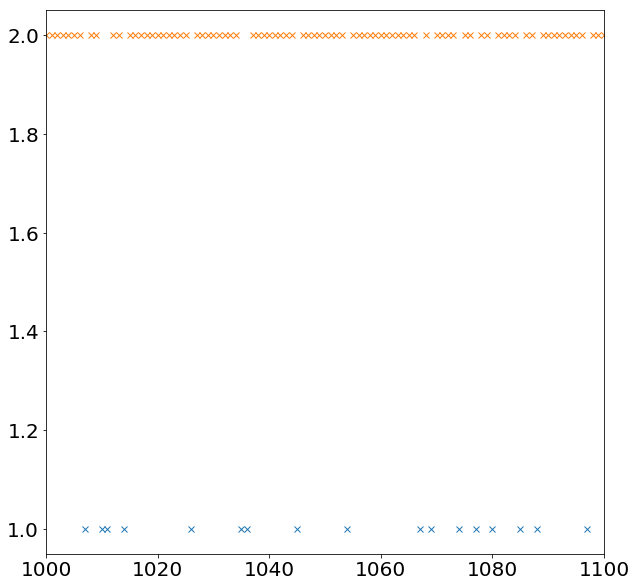

In [268]:
plt.figure(figsize=(10,10))

plt.plot(test_indicies[0],np.ones(len(test_indicies[0])),'x')
plt.plot(train_indicies[0],np.ones(len(train_indicies[0]))+1,'x')
plt.xlim(1000,1100)

In [264]:
len(train_indicies[3])

3384

In [220]:
sklearn.model_selection.KFold(n_splits=5, shuffle=True)
get_n_splits(X=None, y=None)

KFold(n_splits=5, random_state=None, shuffle=True)

In [216]:
model.score(X,Y)

0.9101361413418396

In [166]:
prediction = model.predict(X)

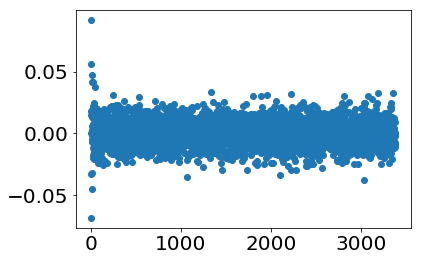

In [217]:
plt.plot(model.coef_,'o')

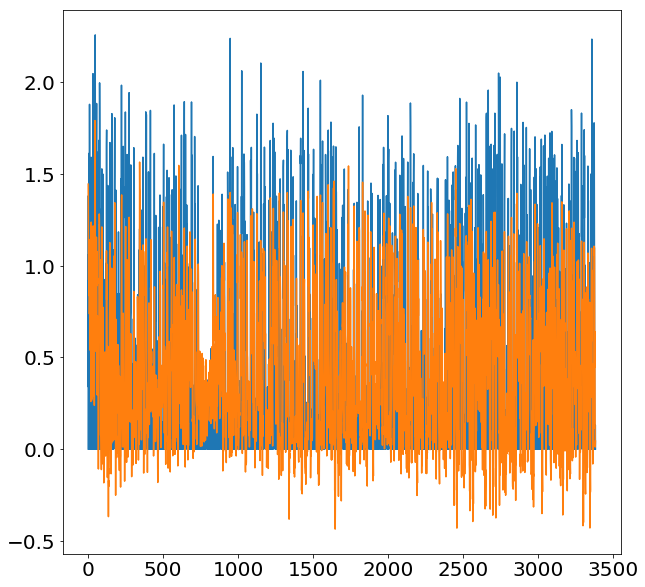

In [171]:
plt.figure(figsize=(10,10))
plt.plot(Y)
plt.plot(prediction)
#plt.xlim(2000,2200)

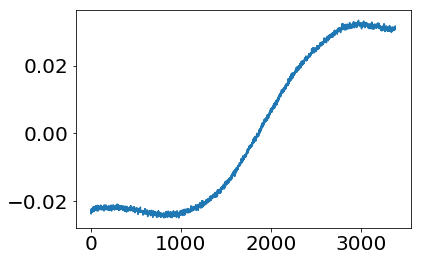

In [124]:
plt.plot(temporal[fly][:,np.argmax(model.coef_)]) #time by pc

In [59]:
np.argmax(model.coef_)

624

In [299]:
i=1
file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_vectors_ztrim.npy'
vectors = np.load(file).real
print(f'vectors are {vectors.shape} voxel by PC')

file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_values_ztrim.npy'
values = np.load(file).real
values.shape

vectors are (26840, 26840) voxel by PC


(26840,)

In [2]:
file = F'/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/20210214_eigen_values_ztrim.npy'
values = np.load(file).real
values.shape

(26840,)

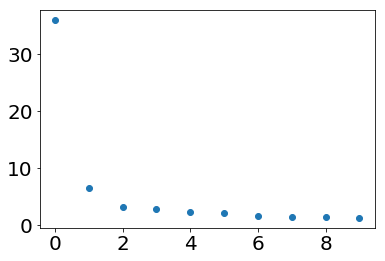

In [7]:
plt.plot(values[:10],'o')

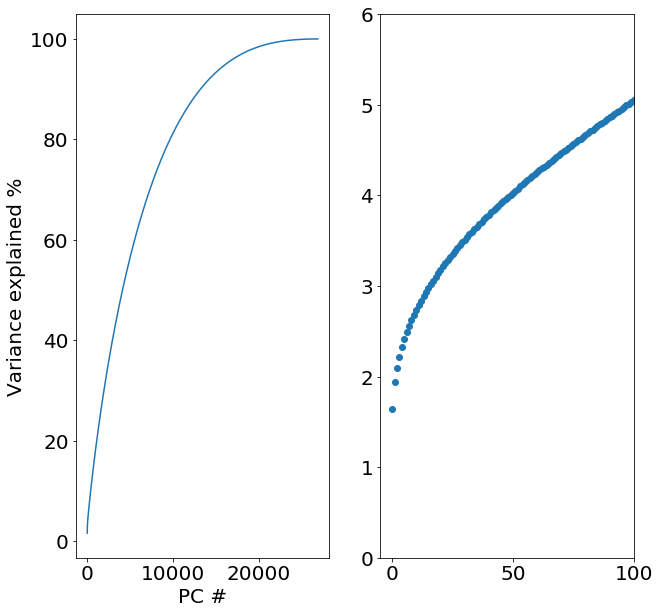

In [343]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)

total = np.sum(values)
plt.plot(np.cumsum(np.sort(values)[::-1])/total*100)
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Variance explained %')
plt.xlabel('PC #')

plt.subplot(1,2,2)
plt.plot(np.cumsum(np.sort(values)[::-1])/total*100,'o')
plt.xlim(-5,100)
plt.ylim(0,6)

save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
plt.savefig(fname,dpi=300,bbox_inches='tight')

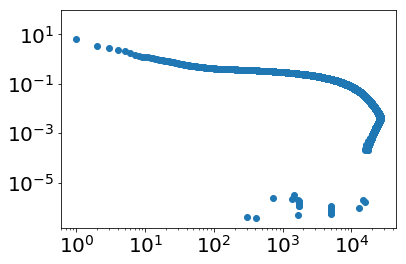

In [319]:
plt.plot(values[:],'o')
plt.yscale('log')
plt.xscale('log')

In [300]:
labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20210130_superv_depth_correction/labels.pickle'
with open(labels_file, 'rb') as handle:
    cluster_model_labels = pickle.load(handle)

In [301]:
running_sum = 0
new = []
for z in range(9,49-9):
    num_clusters = len(np.unique(cluster_model_labels[z]))
    new.append(vectors[running_sum:num_clusters+running_sum,:])
    running_sum += num_clusters

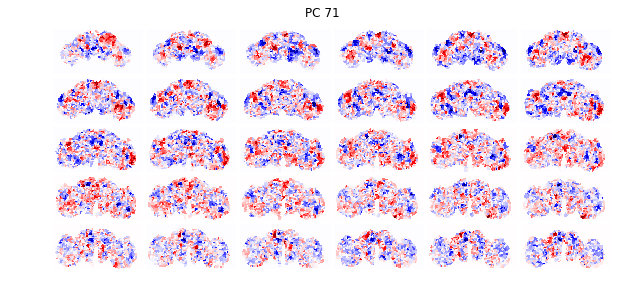

In [312]:
vmin = -.025
vmax = .025
pc = 70

fig = plt.figure(figsize=(10,10))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 6), axes_pad=.05)
for i, z in enumerate(range(9,49-10)):
    colored_by_betas = np.zeros((256*128))
    for cluster_num in range(len(np.unique(cluster_model_labels[z]))):
        cluster_indicies = np.where(cluster_model_labels[z][:]==cluster_num)[0]
        colored_by_betas[cluster_indicies] = new[z-9][cluster_num,pc]
    colored_by_betas = colored_by_betas.reshape(256,128)
    
    cax = grid[i].imshow(colored_by_betas.T,vmin=vmin,vmax=vmax,cmap='seismic_r');

for i in range(30):
    grid[i].axis('off')

plt.suptitle(F'PC {pc+1}',y=.7,fontsize=12)
save_path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/figs'
timestr = time.strftime("%Y%m%d-%H%M%S")
fname = os.path.join(save_path, f'{timestr}')
#plt.savefig(fname,dpi=300,bbox_inches='tight')

In [ ]:
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
alphas = [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e0,1e1,1e2,1e3,1e4,1e5,1e6,1e7]
num_pcss = [1,10,30,100,250,500,1000,2000]

fly_scores = {}
for fly in fly_names:
    print(fly)
    t0=time.time()
    all_all_scores = []
    for num_pcs in num_pcss:
        print(num_pcs)
        Y = flies[fly].fictrac.fictrac['Y_pos'][z]
        X = temporal[fly][:,:num_pcs] #time by pc

        all_scores = []
        for alpha in alphas:
            scores = []
            for fold in range(folds):
                model = Ridge(alpha=alpha).fit(X[train_indicies[fold],:],Y[train_indicies[fold]])
                scores.append(model.score(X[test_indicies[fold],:],Y[test_indicies[fold]]))
            all_scores.append(np.mean(scores))
        all_all_scores.append(all_scores)
    print(time.time()-t0)
    
    max_scores_per_pcs = []
    for i,num_pcs in enumerate(num_pcss):
        max_scores_per_pcs.append(np.max(all_all_scores[i]))
    
    fly_scores[fly] = max_scores_per_pcs